In [1]:
!git clone https://github.com/Etienne-bdt/BEI-SIA25
!unzip /content/BEI-SIA25/data.zip -d /content/BEI-SIA25/

Cloning into 'BEI-SIA25'...
remote: Enumerating objects: 244, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 244 (delta 63), reused 48 (delta 48), pack-reused 148 (from 3)
Receiving objects: 100% (244/244), 110.25 MiB | 16.19 MiB/s, done.
Resolving deltas: 100% (114/114), done.
Archive:  /content/BEI-SIA25/data.zip
   creating: /content/BEI-SIA25/data/
   creating: /content/BEI-SIA25/data/31000/
   creating: /content/BEI-SIA25/data/31000/patches/
  inflating: /content/BEI-SIA25/data/31000/patches/192_192_after.npy  
  inflating: /content/BEI-SIA25/data/31000/patches/192_192_before.npy  
  inflating: /content/BEI-SIA25/data/31000/patches/192_192_mask.npy  
  inflating: /content/BEI-SIA25/data/31000/patches/448_384_after.npy  
  inflating: /content/BEI-SIA25/data/31000/patches/448_384_before.npy  
  inflating: /content/BEI-SIA25/data/31000/patches/448_384_mask.npy  
  inflating: /content/BEI-SIA25/data/31000/patches/448_

In [2]:
import sys
sys.path.append("/content/BEI-SIA25")

In [3]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

from utils.dataloader import CadastreSen2Dataset
from utils.index_calculation import BSI, NDBI, NDMI, NDVI, NDWI

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the data

Get the data

Prepare pytorch dataset

In [5]:
dataset = CadastreSen2Dataset(image_path="/content/BEI-SIA25/data/")

Prepare dataloader

In [40]:
batch_size = 16
num_threads = 0

#Split into train and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_threads)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_threads)

# Model definition

In [72]:
class Conv2DRegressionModel(nn.Module):
    def __init__(self, int_channels: int = 11):
        super(Conv2DRegressionModel, self).__init__()
        self.nb_channel = int_channels
        self.enc1 = nn.Sequential(
            nn.Conv2d(int_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.enc4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(2),
            nn.Tanh()
        )

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        y = self.enc1(X)
        enc1_out = y
        y = self.enc2(y)
        enc2_out = y
        y = self.enc3(y)
        enc3_out = y
        y = self.enc4(y)
        y = self.dec4(y)
        y = torch.cat((y, enc3_out), dim=1)
        y = self.dec3(y)
        y = torch.cat((y, enc2_out), dim=1)
        y = self.dec2(y)
        y = torch.cat((y, enc1_out), dim=1)
        y = self.dec1(y)

        return y

class DiffusionModel(nn.Module):
    def __init__(self, timesteps=1000, beta_start=0.0001, beta_end=0.02):
        super(DiffusionModel, self).__init__()
        self.timesteps = timesteps
        self.beta = torch.linspace(beta_start, beta_end, timesteps).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_cumprod = torch.cumprod(self.alpha, dim=0).to(device)
        self.alpha_cumprod_prev = torch.cat([torch.tensor([1.0]).to(device), self.alpha_cumprod[:-1]]).to(device)
        self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod).to(device)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1.0 - self.alpha_cumprod).to(device)
        self.posterior_variance = self.beta * (1.0 - self.alpha_cumprod_prev) / (1.0 - self.alpha_cumprod)

        self.model = nn.Sequential(
            nn.Conv2d(11, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1)
        )

    def forward(self, x, mask, t):
        noise = torch.randn_like(x).to(device)
        x_t = self.sqrt_alpha_cumprod[t] * x + self.sqrt_one_minus_alpha_cumprod[t] * noise
        return self.model(torch.cat((x_t * (1 - mask), mask), dim=1))

    def p_losses(self, x_start, mask, t):
        noise = torch.randn_like(x_start)
        x_noisy = self.sqrt_alpha_cumprod[t] * x_start + self.sqrt_one_minus_alpha_cumprod[t] * noise
        predicted_noise = self.forward(x_noisy, mask, t)
        return nn.MSELoss()(predicted_noise, noise)

    def sample(self, x, mask):
        for t in reversed(range(self.timesteps)):
            t_tensor = torch.tensor([t]).to(device)
            predicted_noise = self.forward(x, mask, t_tensor)
            if t > 0:
                noise = torch.randn_like(x)
                x = (x - (1 - self.alpha[t]) / torch.sqrt(1 - self.alpha_cumprod[t]) * predicted_noise) / torch.sqrt(self.alpha[t]) + torch.sqrt(self.posterior_variance[t]) * noise
            else:
                x = (x - (1 - self.alpha[t]) / torch.sqrt(1 - self.alpha_cumprod[t]) * predicted_noise) / torch.sqrt(self.alpha[t])
        return x

# Train the model

In [91]:
from skimage.metrics import structural_similarity as ssim
import ignite.metrics as igm

In [94]:
n_epochs = 50
learning_rate = 0.001

model = Conv2DRegressionModel()
model = model.to(device)


metric = igm.SSIM(data_range=2.0)
# metric.attach(igm.default_evaluator, 'ssim')
# preds = torch.rand([4, 3, 16, 16])
# target = preds * 0.75
# state = im.default_evaluator.run([[preds, target]])
# print(state.metrics['ssim'])

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_set_len = len(train_loader)
val_set_len = len(val_loader)

train_loss_comp, val_loss_comp = [], []
train_loss_pred, val_loss_pred = [], []
train_loss_comp_pred, val_loss_comp_pred = [], []
train_loss_tot, val_loss_tot = [], []
train_loss_visu, val_loss_visu = [], []
ssim_vals = []
best_loss=1000000
for epoch in tqdm(range(n_epochs)):
    model.train()
    accu_visual = 0.0
    accu_comp = 0.0
    accu_pred = 0.0
    accu_comp_pred = 0.0
    accu_total = 0.0
    ssim_v = 0

    for x, y, mask in train_loader:
        x,y,mask = x.to(device), y.to(device), mask.to(device)
        x,y,mask = x.float(), y.float(), mask.float()
        optimizer.zero_grad()
        # img_2018, img_2024 = img_2018.to(device), img_2024.to(device)
        # Forward pass
        x=torch.cat([x,mask],axis=1)
        y_pred = model(x) # image 2024 prédite à partir de 2018

        # Ind_comp = NDVI(y_pred)
        # Ind_comp = torch.cat((Ind_comp, NDWI(y_pred)), dim=1)
        # Ind_comp = torch.cat((Ind_comp, NDBI(y_pred)), dim=1)
        # Ind_comp = torch.cat((Ind_comp, NDMI(y_pred)), dim=1)
        # Ind_comp = torch.cat((Ind_comp, BSI(y_pred)), dim=1)

        Ind_real = y[:,5:7,:,:]
        # print("ind real shape",Ind_real.shape)
        # Ind_pred = y_pred[:,5:,:,:]
        Ind_pred = y_pred
        # weights = torch.tensor([0.4, 0.2, 0.2, 0.1, 0.1], device=device) # pondération à ajuster
        # weights = torch.tensor([0.5, 0.5], device=device)

        # visual_loss = loss_fn(y_pred[:,0:3,:,:], y_pred[:,0:3,:,:]) # loss globale
        # loss_comp = sum(w * loss_fn(comp, true) for w, comp, true in zip(weights, Ind_comp, Ind_real)) # comparaison des indices calculés
        loss_pred = loss_fn(y[:,5:7,:,:], y_pred)
        # loss_comp_pred = sum(w * loss_fn(comp, pred) for w, comp, pred in zip(weights, Ind_comp, Ind_pred)) # comparaison des indices calculés et prédits

        # total_loss = visual_loss + loss_comp + loss_pred + loss_comp_pred
        total_loss=loss_pred
        # accu_visual += visual_loss.item()
        # accu_comp += loss_comp.item()
        accu_pred += loss_pred.item()
        # accu_comp_pred += loss_comp_pred.item()
        accu_total += total_loss.item()
        # Backward pass
        total_loss.backward()
        optimizer.step()

    # train_loss_visu.append(accu_visual/val_set_len)
    # train_loss_comp.append(accu_comp / train_set_len)
    train_loss_pred.append(accu_pred / train_set_len)
    # train_loss_comp_pred.append(accu_comp_pred / train_set_len)
    train_loss_tot.append(accu_total / train_set_len)
    # Validation - no gradient & eval mode
    model.eval()
    accu_visual = 0.0
    accu_comp = 0.0
    accu_pred = 0.0
    accu_comp_pred = 0.0
    accu_total = 0.0
    ssim_v = 0
    nb_iter=0
    with torch.no_grad():
        for x, y, mask in val_loader:
            x,y,mask = x.to(device), y.to(device), mask.to(device)
            x,y,mask = x.float(), y.float(), mask.float()

            x=torch.cat([x,mask],axis=1)
            y_pred = model(x)
            # Ind_comp = NDVI(y_pred)
            # Ind_comp = torch.cat((Ind_comp, NDWI(y_pred)), dim=1)
            # Ind_comp = torch.cat((Ind_comp, NDBI(y_pred)), dim=1)
            # Ind_comp = torch.cat((Ind_comp, NDMI(y_pred)), dim=1)
            # Ind_comp = torch.cat((Ind_comp, BSI(y_pred)), dim=1)
            Ind_real = y[:,5:7,:,:]
            # print("ind real shape",Ind_real.shape)
            # Ind_pred = y_pred[:,5:,:,:]
            Ind_pred = y_pred
            # print("ind pred shape",Ind_pred.shape)
            # visual_loss = loss_fn(y_pred[:,0:3,:,:], y_pred[:,0:3,:,:])
            # loss_comp = sum(w * loss_fn(comp, true) for w, comp, true in zip(weights, Ind_comp, Ind_real))
            loss_pred = loss_fn(y[:,5:7,:,:], y_pred)
            # loss_comp_pred = sum(w * loss_fn(comp, pred) for w, comp, pred in zip(weights, Ind_comp, Ind_pred))
            # total_loss = visual_loss + loss_comp + loss_pred + loss_comp_pred
            total_loss=loss_pred
            # accu_visual += visual_loss.item()
            # accu_comp += loss_comp.item()
            accu_pred += loss_pred.item()
            # accu_comp_pred += loss_comp_pred.item()
            accu_total += total_loss.item()

            for i in range(y.shape[0]):
              nb_iter+=1
              ssim_v += ssim(y[i,5,:,:].cpu().detach().numpy(),y_pred[i,0,:,:].cpu().detach().numpy(), data_range=2)
              ssim_v += ssim(y[i,6,:,:].cpu().detach().numpy(),y_pred[i,1,:,:].cpu().detach().numpy(), data_range=2)

    # val_loss_visu.append(accu_visual/val_set_len)
    # val_loss_comp.append(accu_comp / val_set_len)
    val_loss_pred.append(accu_pred / val_set_len)
    # val_loss_comp_pred.append(accu_comp_pred / val_set_len)
    val_loss_tot.append(accu_total / val_set_len)
    ssim_vals.append(ssim_v/ (2*nb_iter))

    if accu_total < best_loss:
        best_loss = accu_total
        torch.save(model.state_dict(), "best_model.pt")

    if epoch % 1 == 0:
        print(f"Epoch {epoch + 1}/{n_epochs} - Train loss: {train_loss_tot[-1]:.4f} - Val loss: {val_loss_tot[-1]:.4f} - SSIM val: {ssim_vals[-1]:.4f}")

    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"model_{epoch}.pt")


  2%|▏         | 1/50 [00:00<00:18,  2.69it/s]

Epoch 1/50 - Train loss: 0.2385 - Val loss: 0.1293 - SSIM val: 0.2463


  4%|▍         | 2/50 [00:00<00:17,  2.75it/s]

Epoch 2/50 - Train loss: 0.1361 - Val loss: 0.1055 - SSIM val: 0.3086


  6%|▌         | 3/50 [00:00<00:15,  3.12it/s]

Epoch 3/50 - Train loss: 0.1189 - Val loss: 0.1139 - SSIM val: 0.3632


  8%|▊         | 4/50 [00:01<00:13,  3.30it/s]

Epoch 4/50 - Train loss: 0.1125 - Val loss: 0.1144 - SSIM val: 0.3481


 10%|█         | 5/50 [00:01<00:13,  3.41it/s]

Epoch 5/50 - Train loss: 0.1003 - Val loss: 0.0974 - SSIM val: 0.3983


 12%|█▏        | 6/50 [00:01<00:12,  3.51it/s]

Epoch 6/50 - Train loss: 0.0958 - Val loss: 0.0821 - SSIM val: 0.4172


 14%|█▍        | 7/50 [00:02<00:12,  3.54it/s]

Epoch 7/50 - Train loss: 0.0906 - Val loss: 0.1061 - SSIM val: 0.3906


 16%|█▌        | 8/50 [00:02<00:11,  3.59it/s]

Epoch 8/50 - Train loss: 0.0811 - Val loss: 0.0752 - SSIM val: 0.4537


 18%|█▊        | 9/50 [00:02<00:11,  3.61it/s]

Epoch 9/50 - Train loss: 0.0785 - Val loss: 0.1080 - SSIM val: 0.4410


 20%|██        | 10/50 [00:02<00:10,  3.67it/s]

Epoch 10/50 - Train loss: 0.0752 - Val loss: 0.1904 - SSIM val: 0.4504


 22%|██▏       | 11/50 [00:03<00:10,  3.66it/s]

Epoch 11/50 - Train loss: 0.0673 - Val loss: 0.0979 - SSIM val: 0.4500


 24%|██▍       | 12/50 [00:03<00:10,  3.64it/s]

Epoch 12/50 - Train loss: 0.0663 - Val loss: 0.0613 - SSIM val: 0.4891


 26%|██▌       | 13/50 [00:03<00:10,  3.44it/s]

Epoch 13/50 - Train loss: 0.0627 - Val loss: 0.0719 - SSIM val: 0.5115


 28%|██▊       | 14/50 [00:04<00:10,  3.28it/s]

Epoch 14/50 - Train loss: 0.0593 - Val loss: 0.0794 - SSIM val: 0.4947


 30%|███       | 15/50 [00:04<00:11,  3.10it/s]

Epoch 15/50 - Train loss: 0.0560 - Val loss: 0.0795 - SSIM val: 0.4484


 32%|███▏      | 16/50 [00:04<00:10,  3.11it/s]

Epoch 16/50 - Train loss: 0.0518 - Val loss: 0.1734 - SSIM val: 0.4918


 34%|███▍      | 17/50 [00:05<00:10,  3.06it/s]

Epoch 17/50 - Train loss: 0.0523 - Val loss: 0.0653 - SSIM val: 0.5416


 36%|███▌      | 18/50 [00:05<00:10,  2.93it/s]

Epoch 18/50 - Train loss: 0.0501 - Val loss: 0.0421 - SSIM val: 0.5616


 38%|███▊      | 19/50 [00:05<00:10,  2.91it/s]

Epoch 19/50 - Train loss: 0.0480 - Val loss: 0.0752 - SSIM val: 0.4986


 40%|████      | 20/50 [00:06<00:10,  2.83it/s]

Epoch 20/50 - Train loss: 0.0471 - Val loss: 0.0446 - SSIM val: 0.5609


 42%|████▏     | 21/50 [00:06<00:09,  2.93it/s]

Epoch 21/50 - Train loss: 0.0509 - Val loss: 0.0679 - SSIM val: 0.5388


 44%|████▍     | 22/50 [00:06<00:08,  3.13it/s]

Epoch 22/50 - Train loss: 0.0443 - Val loss: 0.0583 - SSIM val: 0.5590


 46%|████▌     | 23/50 [00:07<00:08,  3.29it/s]

Epoch 23/50 - Train loss: 0.0441 - Val loss: 0.0531 - SSIM val: 0.5448


 48%|████▊     | 24/50 [00:07<00:07,  3.34it/s]

Epoch 24/50 - Train loss: 0.0445 - Val loss: 0.0407 - SSIM val: 0.5700


 50%|█████     | 25/50 [00:07<00:07,  3.40it/s]

Epoch 25/50 - Train loss: 0.0446 - Val loss: 0.2407 - SSIM val: 0.4201


 52%|█████▏    | 26/50 [00:07<00:06,  3.51it/s]

Epoch 26/50 - Train loss: 0.0462 - Val loss: 0.0564 - SSIM val: 0.5418


 54%|█████▍    | 27/50 [00:08<00:06,  3.57it/s]

Epoch 27/50 - Train loss: 0.0457 - Val loss: 0.0479 - SSIM val: 0.5389


 56%|█████▌    | 28/50 [00:08<00:06,  3.54it/s]

Epoch 28/50 - Train loss: 0.0417 - Val loss: 0.0774 - SSIM val: 0.4575


 58%|█████▊    | 29/50 [00:08<00:05,  3.58it/s]

Epoch 29/50 - Train loss: 0.0399 - Val loss: 0.0331 - SSIM val: 0.5859


 60%|██████    | 30/50 [00:09<00:05,  3.61it/s]

Epoch 30/50 - Train loss: 0.0390 - Val loss: 0.0553 - SSIM val: 0.5456


 62%|██████▏   | 31/50 [00:09<00:05,  3.48it/s]

Epoch 31/50 - Train loss: 0.0401 - Val loss: 0.0822 - SSIM val: 0.5357


 64%|██████▍   | 32/50 [00:09<00:05,  3.56it/s]

Epoch 32/50 - Train loss: 0.0425 - Val loss: 0.0581 - SSIM val: 0.5607


 66%|██████▌   | 33/50 [00:09<00:04,  3.63it/s]

Epoch 33/50 - Train loss: 0.0376 - Val loss: 0.0354 - SSIM val: 0.5724


 68%|██████▊   | 34/50 [00:10<00:04,  3.68it/s]

Epoch 34/50 - Train loss: 0.0367 - Val loss: 0.0472 - SSIM val: 0.5491


 70%|███████   | 35/50 [00:10<00:04,  3.69it/s]

Epoch 35/50 - Train loss: 0.0378 - Val loss: 0.0491 - SSIM val: 0.5790


 72%|███████▏  | 36/50 [00:10<00:03,  3.68it/s]

Epoch 36/50 - Train loss: 0.0368 - Val loss: 0.0640 - SSIM val: 0.5290


 74%|███████▍  | 37/50 [00:10<00:03,  3.69it/s]

Epoch 37/50 - Train loss: 0.0370 - Val loss: 0.0423 - SSIM val: 0.5963


 76%|███████▌  | 38/50 [00:11<00:03,  3.67it/s]

Epoch 38/50 - Train loss: 0.0386 - Val loss: 0.0328 - SSIM val: 0.5851


 78%|███████▊  | 39/50 [00:11<00:03,  3.62it/s]

Epoch 39/50 - Train loss: 0.0365 - Val loss: 0.0418 - SSIM val: 0.5496


 80%|████████  | 40/50 [00:11<00:02,  3.64it/s]

Epoch 40/50 - Train loss: 0.0343 - Val loss: 0.0462 - SSIM val: 0.5739


 82%|████████▏ | 41/50 [00:12<00:02,  3.62it/s]

Epoch 41/50 - Train loss: 0.0327 - Val loss: 0.0258 - SSIM val: 0.5909


 84%|████████▍ | 42/50 [00:12<00:02,  3.65it/s]

Epoch 42/50 - Train loss: 0.0353 - Val loss: 0.0423 - SSIM val: 0.5499


 86%|████████▌ | 43/50 [00:12<00:01,  3.61it/s]

Epoch 43/50 - Train loss: 0.0349 - Val loss: 0.0973 - SSIM val: 0.5240


 88%|████████▊ | 44/50 [00:12<00:01,  3.64it/s]

Epoch 44/50 - Train loss: 0.0346 - Val loss: 0.0455 - SSIM val: 0.5727


 90%|█████████ | 45/50 [00:13<00:01,  3.66it/s]

Epoch 45/50 - Train loss: 0.0343 - Val loss: 0.0440 - SSIM val: 0.5700


 92%|█████████▏| 46/50 [00:13<00:01,  3.66it/s]

Epoch 46/50 - Train loss: 0.0366 - Val loss: 0.0285 - SSIM val: 0.5945


 94%|█████████▍| 47/50 [00:13<00:00,  3.66it/s]

Epoch 47/50 - Train loss: 0.0378 - Val loss: 0.0913 - SSIM val: 0.5063


 96%|█████████▌| 48/50 [00:13<00:00,  3.67it/s]

Epoch 48/50 - Train loss: 0.0474 - Val loss: 0.1039 - SSIM val: 0.5089


 98%|█████████▊| 49/50 [00:14<00:00,  3.68it/s]

Epoch 49/50 - Train loss: 0.0438 - Val loss: 0.0464 - SSIM val: 0.5592


100%|██████████| 50/50 [00:14<00:00,  3.45it/s]

Epoch 50/50 - Train loss: 0.0387 - Val loss: 0.0304 - SSIM val: 0.5962


In [65]:
x,y,m = next(iter(val_loader))


tensor(-1.0000, dtype=torch.float64)
tensor(0.3117, dtype=torch.float64)


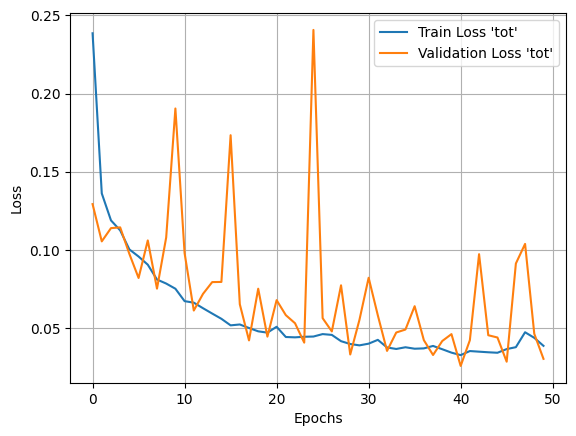

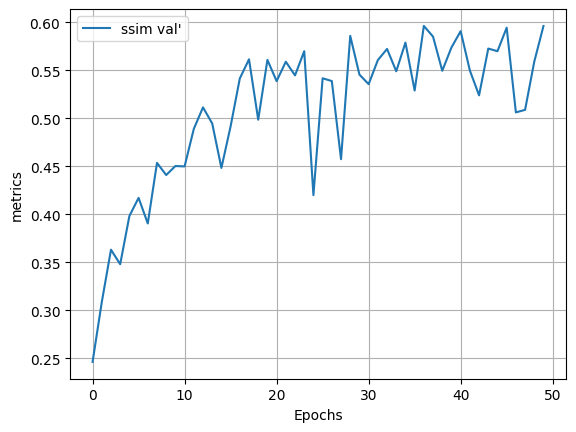

In [95]:
# plt.plot(train_loss_visu, label="Train Loss 'visu'")
# plt.plot(val_loss_visu, label="Validation Loss 'visu'")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.grid()


# plt.plot(train_loss_comp, label="Train Loss 'comp'")
# plt.plot(val_loss_comp, label="Validation Loss 'comp'")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.grid()
# plt.show()

# plt.plot(train_loss_pred, label="Train Loss 'pred'")
# plt.plot(val_loss_pred, label="Validation Loss 'pred'")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.grid()
# plt.show()

# plt.plot(train_loss_comp_pred, label="Train Loss 'comp_pred'")
# plt.plot(val_loss_comp_pred, label="Validation Loss 'comp_pred'")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.grid()
# plt.show()

plt.plot(train_loss_tot, label="Train Loss 'tot'")
plt.plot(val_loss_tot, label="Validation Loss 'tot'")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

plt.plot(ssim_vals, label="ssim val'")
# plt.plot(val_loss_visu, label="Validation Loss 'visu'")
plt.xlabel("Epochs")
plt.ylabel("metrics")
plt.legend()
plt.grid()

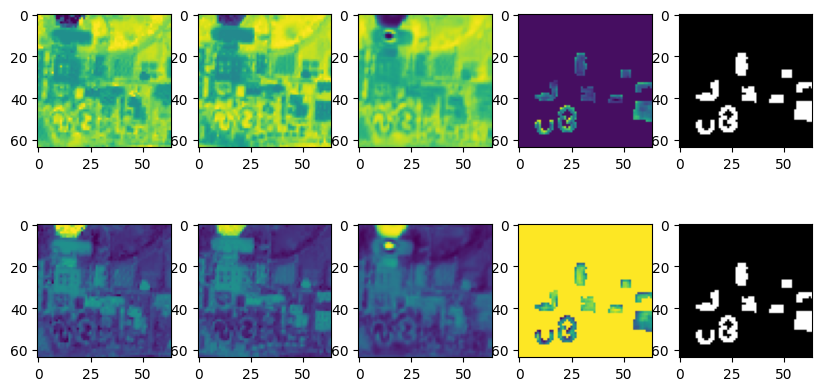

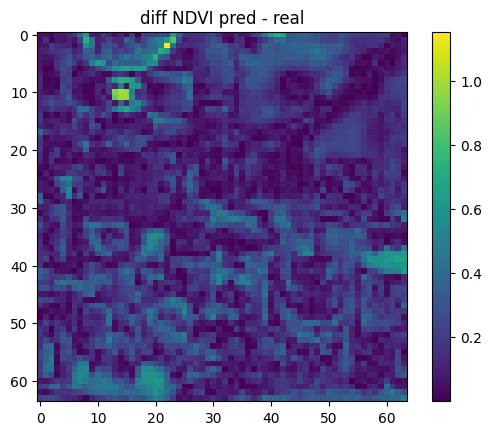

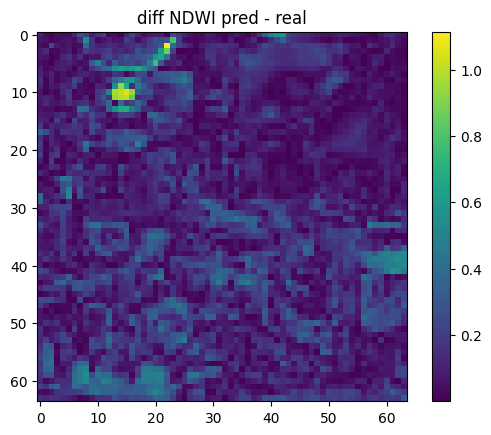

mean diff NDVI pred - real 0.1768727
mean diff NDWI pred - real 0.13662833


In [96]:
model.cpu()

x,y,mask = next(iter(val_loader))
x,y,mask = x.float(), y.float(), mask.float()
# x,y,mask = x[0:1,:,:,:], y[0:1,:,:,:], mask[0:1,:,:,:]
# x,y,mask = x.cpu(), y.tocpu(), mask.to(device)
x=torch.cat([x,mask],axis=1)
y_pred = model(x)
batch_img=0
fig, ax = plt.subplots(2, 5, figsize=(10,5))
# ax[0, 0].imshow((x[batch_img, 0:3, :, :]).permute(1,2,0).detach().numpy())
# ax[0, 1].imshow(y[batch_img, 0:3, :, :].permute(1,2,0).detach().numpy())
# ax[0, 2].imshow(y_pred[batch_img, 0:3, :, :].permute(1,2,0).detach().numpy())

# ax[1, 0].imshow(x[batch_img, 5, :, :].detach().numpy())
# ax[1, 1].imshow(y[batch_img, 5, :, :].detach().numpy())
# ax[1, 2].imshow(y_pred[batch_img, 5, :, :].detach().numpy())
ax[0, 0].imshow((x[batch_img, 5, :, :]).detach().numpy())
ax[0, 1].imshow(y[batch_img, 5, :, :].detach().numpy())
ax[0, 2].imshow(y_pred[batch_img, 0, :, :].detach().numpy())
ax[0, 3].imshow((y_pred[batch_img, 0, :, :]*mask[batch_img,0,:,:]).detach().numpy())
ax[0,4].imshow(mask[batch_img,0,:,:].detach().numpy(),cmap="gray")
ax[1, 0].imshow(x[batch_img, 6, :, :].detach().numpy())
ax[1, 1].imshow(y[batch_img, 6, :, :].detach().numpy())
ax[1, 2].imshow(y_pred[batch_img, 1, :, :].detach().numpy())
ax[1, 3].imshow((y_pred[batch_img, 1, :, :]*mask[batch_img,0,:,:]).detach().numpy())
ax[1,4].imshow(mask[batch_img,0,:,:].detach().numpy(),cmap="gray")
# ax[2, 0].imshow(x[batch_img, 6, :, :].detach().numpy())
# ax[2, 1].imshow(y[batch_img, 6, :, :].detach().numpy())
# # ax[2, 2].imshow(y_pred[batch_img, 6, :, :].detach().numpy())
# ax[3, 0].imshow(x[batch_img, 7, :, :].detach().numpy())
# ax[3, 1].imshow(y[batch_img, 7, :, :].detach().numpy())
# # ax[3, 2].imshow(y_pred[batch_img, 7, :, :].detach().numpy())
# ax[4, 0].imshow(x[batch_img, 8, :, :].detach().numpy())
# ax[4, 1].imshow(y[batch_img, 8, :, :].detach().numpy())
# # ax[4, 2].imshow(y_pred[batch_img, 8, :, :].detach().numpy())
# ax[5, 0].imshow(x[batch_img, 9, :, :].detach().numpy())
# ax[5, 1].imshow(y[batch_img, 9, :, :].detach().numpy())
# # ax[5, 2].imshow(y_pred[batch_img, 9, :, :].detach().numpy())
plt.show()





plt.figure()
plt.imshow(np.abs((y_pred[batch_img, 0, :, :]-y[batch_img, 5, :, :]).detach().numpy()))
plt.colorbar()
plt.title("diff NDVI pred - real")
plt.show()

plt.figure()
plt.imshow(np.abs((y_pred[batch_img, 1, :, :]-y[batch_img, 6, :, :]).detach().numpy()))
plt.colorbar()
plt.title("diff NDWI pred - real")
plt.show()

print("mean diff NDVI pred - real",np.mean(np.abs(((y_pred[batch_img, 0, :, :]-y[batch_img, 5, :, :]).detach().numpy()))))
print("mean diff NDWI pred - real",np.mean(np.abs((y_pred[batch_img, 1, :, :]-y[batch_img, 6, :, :]).detach().numpy())))